In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings 

warnings.simplefilter("ignore")

In [2]:
df = pd.read_excel("BASE_PREDIÇÃO_2025.xlsx")

In [3]:
df.head()

,ID,NATZ,DIASEM,TIPDIA,FASEMÊS,TPMÊS,TPHORA,BAIRRO,ZONA,CRIME
0,1,1,4,1,1,1,6,5,2,1
1,2,1,4,1,1,1,2,2,3,0
2,3,3,5,1,1,1,3,1,1,1
3,4,3,5,1,1,1,2,4,3,0
4,5,1,5,1,1,1,5,1,1,1


Fold 1: 62.4%
Fold 2: 67.74%
Fold 3: 66.15%
Fold 4: 67.18%
Fold 5: 71.43%
Fold 6: 68.75%
Fold 7: 61.79%
Fold 8: 75.38%
Fold 9: 67.21%
Fold 10: 63.57%

Média dos Scores de F1: 67.16%
Desvio Padrão dos Scores: 3.93%

Test Accuracy: 0.69

Feature Importances:
  Feature Id  Importances
0     BAIRRO    88.466076
1     TIPDIA     3.057346
2    FASEMÊS     2.935674
3       ZONA     2.027362
4     TPHORA     1.953071
5      TPMÊS     1.428584
6       NATZ     0.131887
7     DIASEM     0.000000


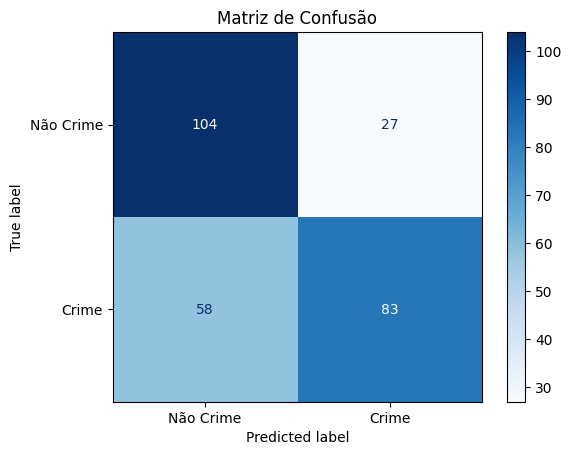

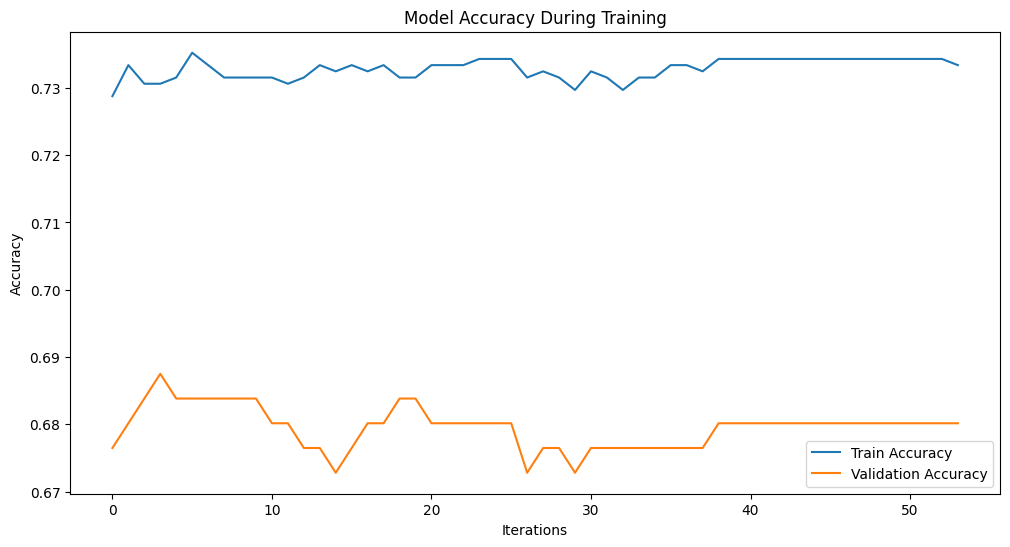

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score

# Carregar os dados (substitua 'df' pelos seus dados)
# df = pd.read_csv("seu_arquivo.csv")  # Certifique-se de carregar os dados adequados

# Divisão dos dados
X = df.drop(columns=["CRIME", "ID"])  # Substitua "CRIME" e "ID" pelos nomes reais das colunas
y = df["CRIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação do modelo CatBoost
model = CatBoostClassifier(
    iterations=1000,            # Número máximo de iterações
    learning_rate=0.01,         # Taxa de aprendizado
    depth=6,                    # Profundidade das árvores
    l2_leaf_reg=3,              # Regularização L2
    loss_function='Logloss',    # Função de perda para classificação binária
    eval_metric='Accuracy',     # Métrica de avaliação
    random_seed=42,             # Reprodutibilidade
    verbose=0,                # Exibir logs a cada 100 iterações
    early_stopping_rounds=50    # Parar se não melhorar após 50 iterações
)

# Pipeline (se precisar de transformação, pode ser incluída aqui)
pipeline = Pipeline([
    ('model', model)
])

# K-Fold Cross Validation com StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Avaliação com cross_val_score e F1 Score
scores = cross_val_score(
    pipeline,
    X,  # Dados de entrada
    y,  # Rótulos
    cv=kfold,
    scoring=make_scorer(f1_score),  # Métrica: F1 Score
    verbose=0
)

# Exibir os resultados dos folds
for i, score in enumerate(scores):
    print(f"Fold {i + 1}: {round(score * 100, 2)}%")

print(f"\nMédia dos Scores de F1: {scores.mean() * 100:.2f}%")
print(f"Desvio Padrão dos Scores: {scores.std() * 100:.2f}%")

# Treinamento final do modelo com o conjunto de treino completo
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # Dados de validação para early stopping
    use_best_model=True         # Usa o melhor modelo baseado no conjunto de validação
)

# Previsões
predictions = model.predict(X_test)

# Avaliação final do Modelo
accuracy = accuracy_score(y_test, predictions)
print(f"\nTest Accuracy: {accuracy:.2f}")

# Importância das variáveis
feature_importances = model.get_feature_importance(prettified=True)
print("\nFeature Importances:")
print(feature_importances)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Não Crime", "Crime"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Plot do Histórico de Treinamento
plt.figure(figsize=(12, 6))

# Resultados do treinamento
results = model.get_evals_result()
train_accuracy = results['learn']['Accuracy']
val_accuracy = results['validation']['Accuracy']

# Gráficos de Métricas
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy During Training')
plt.legend()
plt.show()


In [5]:
import joblib 

joblib.dump(pipeline, "modelo-predicao.pkl")

['modelo-predicao.pkl']

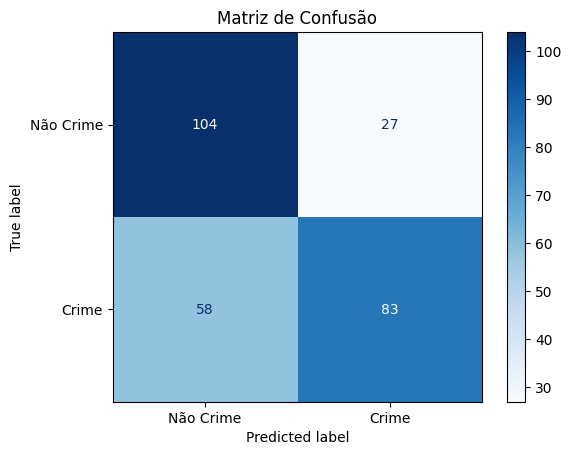

In [6]:

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions)

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Não Crime", "Crime"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

In [11]:
df["PREVISAO"] = pipeline.predict(df)
df.head() 

,ID,NATZ,DIASEM,TIPDIA,FASEMÊS,TPMÊS,TPHORA,BAIRRO,ZONA,CRIME,PREVISAO
0,1,1,4,1,1,1,6,5,2,1,0
1,2,1,4,1,1,1,2,2,3,0,1
2,3,3,5,1,1,1,3,1,1,1,1
3,4,3,5,1,1,1,2,4,3,0,0
4,5,1,5,1,1,1,5,1,1,1,1


In [7]:
import joblib 

joblib.dump(pipeline, "model-catboost-violencia.pkl")

['model-catboost-violencia.pkl']